# General

## Imports


In [ ]:
!pip install textblob
!pip install beautifulsoup4
!pip install simple-colors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from textblob import TextBlob
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from simple_colors import *

sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)
warnings.filterwarnings('ignore')

## Data description and reading

**Description:** 
* We have dataset for binary sentiment classification. 
* We provide a set of 50,000 highly polar movie reviews for training and testing.
* There are no missing values in the dataset
* Target is sentiment variable which has positive or negative value
* Dependent variable is review feature which is text in English

In [ ]:
# Dataset upload
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/LargeMovieReviewDataset.csv

In [ ]:
# Read the data
messages = pd.read_csv('LargeMovieReviewDataset.csv')

In [ ]:
# Data description
messages.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


From description we can see that there are not unique values for review feature that can be deleted as those are duplicates

In [ ]:
# Deleting duplicated records
messages = messages.drop_duplicates()

In [ ]:
# Separating the target y
y = messages.sentiment

As reviews are written in English - stopwords are used for this language

In [ ]:
# Stopwords from Enlgish language for future use
stop_words = stopwords.words('english')

# EDA

## Target
First let's check sentiment distribution

In [ ]:
# Percentage of positive and negative values for sentiment variable
y.value_counts() / y.shape[0] * 100

positive    50.187568
negative    49.812432
Name: sentiment, dtype: float64

Text(0.5, 1.0, 'Sentiment distribution')

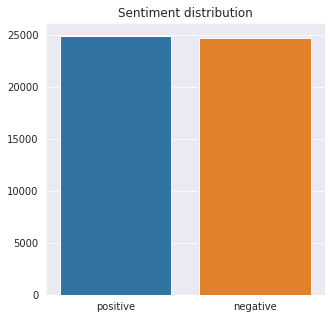

In [ ]:
# Visualizing target variable Sentiment distribution
sns.barplot(y.value_counts().index, y.value_counts().values)
plt.title("Sentiment distribution")

We can see that our dataset is almost perfectly balanced and we have nearly the same amount of records for negative and positive reviews

In [ ]:
# Encoding target with numerical 1 and 0 values for future use
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

## Statistics for review feature
* Will add some statistics about review to check if it's differ for positive and negative sentiment
* Most of statistics are related to review text structure
* Subjectivity it's statistic for checking how subjective is review text

In [ ]:
# Adding some statistics about X feature 'review' 
stats = pd.DataFrame()
stats['review_len'] = messages['review'].astype(str).apply(len)
stats['word_count'] = messages['review'].apply(lambda x: len(str(x).split()))
stats['spaces'] = stats['word_count']-1
stats['avg_word_len'] = (stats['review_len']-stats['spaces']) / stats['word_count']
stats['subjectivity'] = messages['review'].map(lambda text: TextBlob(text).sentiment.subjectivity)
stats.head()

,review_len,word_count,spaces,avg_word_len,subjectivity
0,1761,307,306,4.739414,0.490369
1,998,162,161,5.166667,0.559343
2,926,166,165,4.584337,0.658730
3,748,138,137,4.427536,0.454167
4,1317,230,229,4.730435,0.452916


In [ ]:
# Checking some general statistics 
stats.describe()

,review_len,word_count,spaces,avg_word_len,subjectivity
count,49582.000000,49582.000000,49582.000000,49582.000000,49582.000000
mean,1310.568230,231.350167,230.350167,4.641052,0.530613
std,990.762238,171.542020,171.542020,0.340570,0.092839
min,32.000000,4.000000,3.000000,1.239865,0.000000
25%,699.000000,126.000000,125.000000,4.418367,0.472222
50%,971.000000,173.000000,172.000000,4.627119,0.528825
75%,1592.000000,281.000000,280.000000,4.847673,0.587664
max,13704.000000,2470.000000,2469.000000,12.290909,1.000000


* From some statistical metrics we can see that review length is very different for dataset, but mainly it is more then 699 symbols or 126 words
* Average word length is mainly in range 4-5 words
* Subjectivity is mainly closer to subjective then objective, but main data is concentrated around 0.5 
* All statistics have outliers
* Let's check visual representation of it

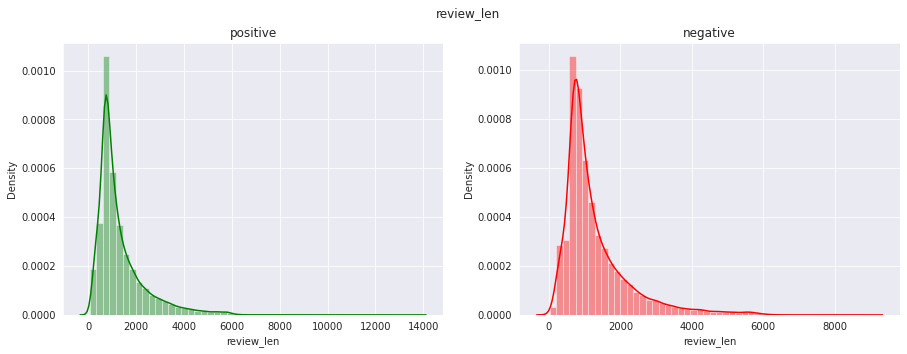

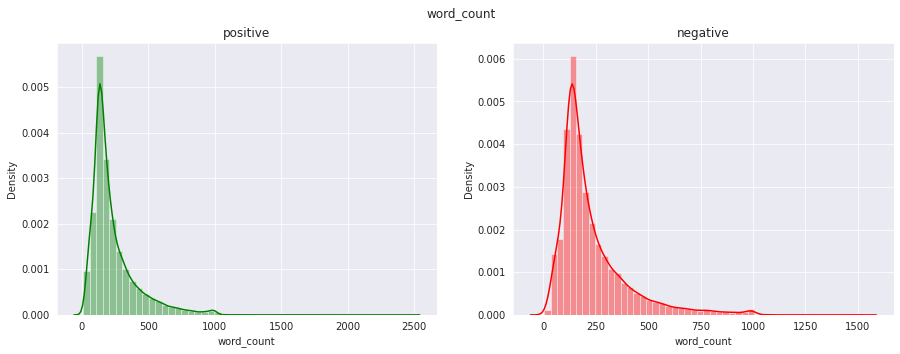

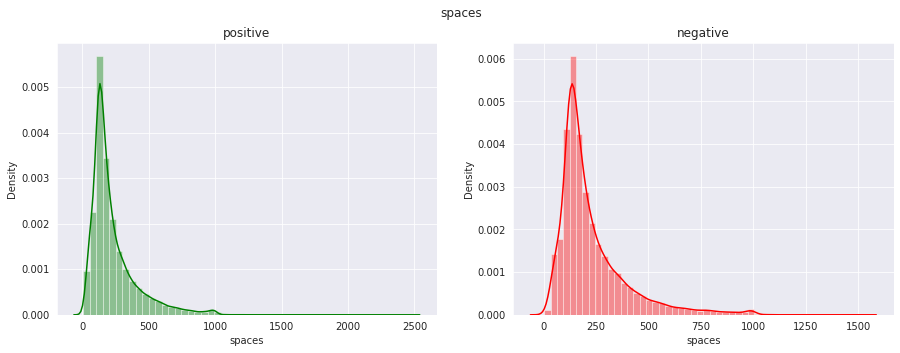

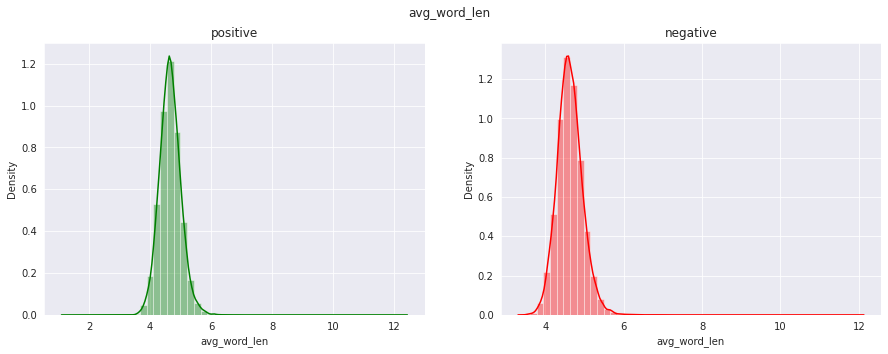

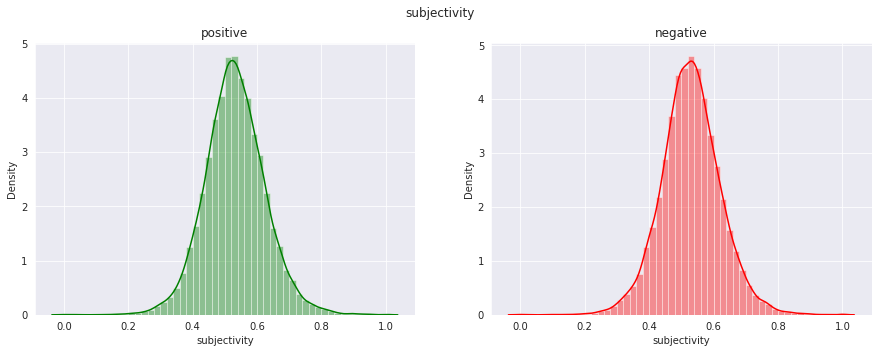

In [ ]:
# Visualizion for every statistical columns distribution for positive and negative Target
for stat in stats.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(stats[y == 1][stat], ax=ax1, color='green')
    ax1.set_title('positive')
    sns.distplot(stats[y == 0][stat], ax=ax2, color='red')
    ax2.set_title('negative')
    fig.suptitle(stat)

* Distribution for negative and positive review are almost the same from analyzed statistics point of view, which means that target doesn't depend on review length or subjectivity
* To check what are the most frequent words for dataset before cleaning we'll use wordcloud

(-0.5, 399.5, 199.5, -0.5)

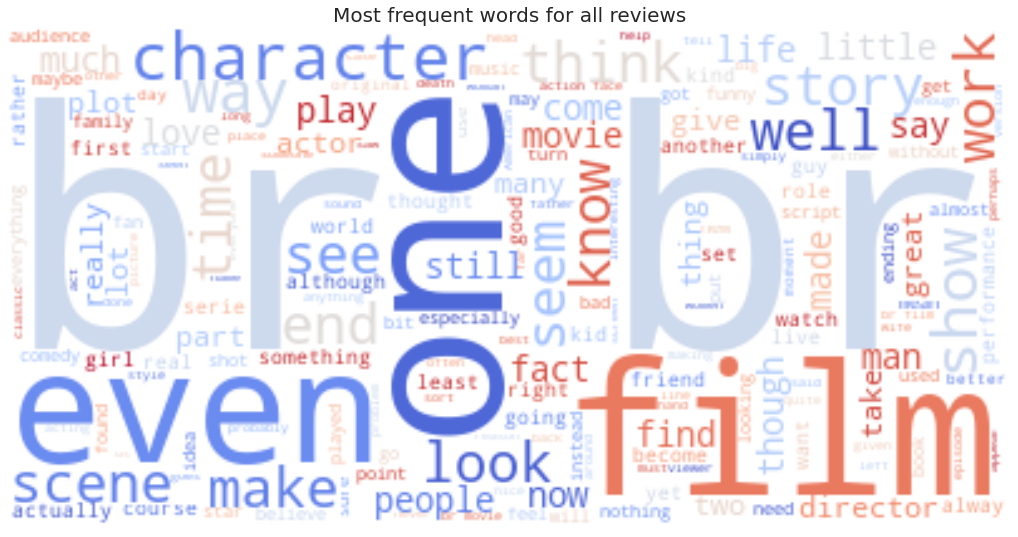

In [ ]:
# Visualization of most frequent words in dataset before cleaning
wc = WordCloud(max_font_size=150, max_words=500, background_color="white", colormap='coolwarm')
wc = wc.generate(' '.join(messages['review']))
plt.rcParams['figure.figsize'] = [18, 16]
plt.imshow(wc, interpolation='bilinear')
plt.title('Most frequent words for all reviews', fontsize=20)
plt.axis('off')

* Here we can see that br is the most frequent one and it is from html, so we need to deal with it during preprocessing
* One and two can be added to stopwords as those are digits

# Text preprocessing 

* First will update stopwords with mentioned numbers and will remove 3 not from stopwords as they can be useful in negative review 

In [ ]:
# Updating stopwords after EDA
stop_words.remove('not')
stop_words.remove("don't")
stop_words.remove("doesn't")
stop_words.append('one')
stop_words.append('two')

In [ ]:
# Creating instances for stemming and lemmatization
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

In [ ]:
# Function for total text preprocessing
def preproc(text, stem=True):
  tokens = []
  sen_cleaned = []

  # Cleaning and tokenization
  for sen in text:
    fil = []
    # sen = i
    soup = BeautifulSoup(sen, "html.parser")  
    sen = soup.get_text(separator=" ") # cleaning from html tags
    sen = sen.lower() # changing to lower case
    sen = re.sub(r'\d+', '', sen) # cleaning from digits
    sen = re.sub(r'[^\w\s]', '', sen) # cleaning from punctuation
    wd = nltk.word_tokenize(sen) # tokenization
    wd = [w for w in wd if not w in stop_words] # removing stopwords

    # Normalisation: stemming or lemmatization
    for word in wd:
      if stem:
        fil.append(stemmer.stem(word))
      else:
        fil.append(lemmatizer.lemmatize(word))
    tokens.append(fil)
    fil_joined =' '.join(word for word in fil)
    sen_cleaned.append(fil_joined)
  return tokens, sen_cleaned

To compare stemming and lemmatization:
* preprocessing will be done for both variants
* then basic estimation will be done for one model to compare both normalisation techniques
* one technique will be selected for future use

In [ ]:
%%time
# Preprocessing with stemming
tokens_st, review_cleaned_st = preproc(messages.review)
# Preprocessing with lemmatization
tokens_lem, review_cleaned_lem = preproc(messages.review, stem=False)

CPU times: user 4min 51s, sys: 2.25 s, total: 4min 54s
Wall time: 4min 55s


In [ ]:
# Function for estimating model with specific normalisation technique
def est_norm(X, y, model, vec):
  cv = vec.fit_transform(X).toarray()
  train_x, test_x, train_y, test_y = train_test_split(cv, y, test_size = 0.20, shuffle=True)
  model.fit(train_x, train_y)
  y_pred_prob = model.predict_proba(test_x)[:,1]
  print('ROC_AUC:', roc_auc_score(test_y, y_pred_prob))

In [ ]:
# Estimating model with stemming preprocessing
vec = TfidfVectorizer(min_df=0.1, max_df=0.85, stop_words=stop_words)
clf_st = MultinomialNB()
print(red('Stemming:', ['bold']))
est_norm(review_cleaned_st, y, clf_st, vec)

# Estimating model with lemmatization preprocessing
clf_lem = MultinomialNB()
print(red('\nLemmatization:', ['bold']))
est_norm(review_cleaned_lem, y, clf_lem, vec)

Stemming:
ROC_AUC: 0.8342520338363999

Lemmatization:
ROC_AUC: 0.8147183102887973


* As we can see in our case stemming shows better results so will be using it in the future

In [ ]:
# Adding cleaned columns to dataset
messages['tokens'] = tokens_st
messages['review_cleaned'] = review_cleaned_st
messages.head()

,review,sentiment,tokens,review_cleaned
0,One of the other reviewers has mentioned that ...,positive,"[review, mention, watch, oz, episod, youll, ho...",review mention watch oz episod youll hook righ...
1,A wonderful little production. <br /><br />The...,positive,"[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,"[basic, there, famili, littl, boy, jake, think...",basic there famili littl boy jake think there ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...


# Word analysis
Will analyse words separately(unigrams) and in pairs(bigrams)

## Unigrams
First will create some useful functions for displaying wordclouds

In [ ]:
# Functions for creating wordclouds which will be used in this section
def plot_wordcloud(text, wc):
  wc = wc.generate(' '.join(text))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')

def compare_wordclouds(text1, text2, wc, title_text):
  plt.rcParams['figure.figsize'] = [26, 16]
  plt.subplot(1, 2, 1)
  plot_wordcloud(text1, wc)
  plt.title(title_text[0], fontsize = 20)

  plt.subplot(1, 2, 2)
  plot_wordcloud(text2, wc)
  plt.title(title_text[1], fontsize = 20)

In [ ]:
# Separation of positive and negative cleaned reviews onto two dataframes
pos_df = messages[y == 1]['review_cleaned']
neg_df = messages[y == 0]['review_cleaned']

In [ ]:
# Creating wordcloud instance 
wc = WordCloud(stopwords=stop_words, max_font_size=50, max_words=100, background_color="white", colormap='coolwarm', random_state=42)

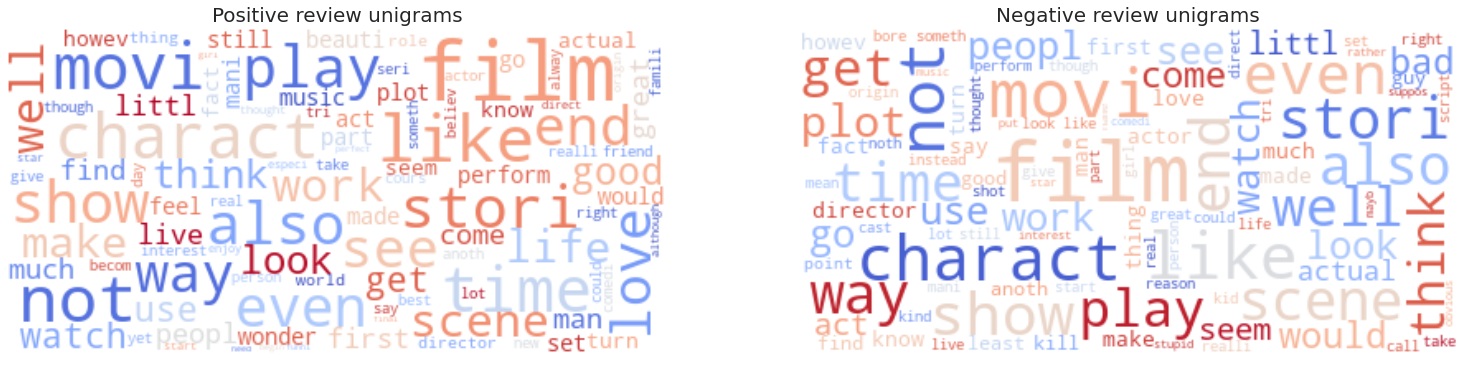

In [ ]:
# Visualization for most frequent words in positive and negative reviews
title_text=['Positive review unigrams', 'Negative review unigrams']
compare_wordclouds(pos_df, neg_df, wc, title_text)

* As we can see the most frequent words are film, movi, like, charact for both sentiments, but for positive we can see **good, love, well, much** and for negative **bad, little**
* Not is represented for both, but it doesn't give any information in unigrams, it need to be analysed in bigrams

## Bigrams

First let's create function for analysing bigrams

In [ ]:
# Function for getting top n pairs of words (bigrams)
def get_top_n_bigram(text, vect, n=20):    
    bow = vec.fit_transform(text)
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
# Vectorizer instance with 2,2 ngram to get pairs
vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words)

In [ ]:
# Applying function to get top n bigrams for positive and negative reviews
pos_cw = get_top_n_bigram(pos_df, vec)
neg_cw = get_top_n_bigram(neg_df, vec)

# Creating dataframes with information about bigrams to use it in plotting
pos_cw_df = pd.DataFrame(pos_cw, columns = ['Review positive' , 'count_p'])
neg_cw_df = pd.DataFrame(neg_cw, columns = ['Review negative' , 'count_n'])

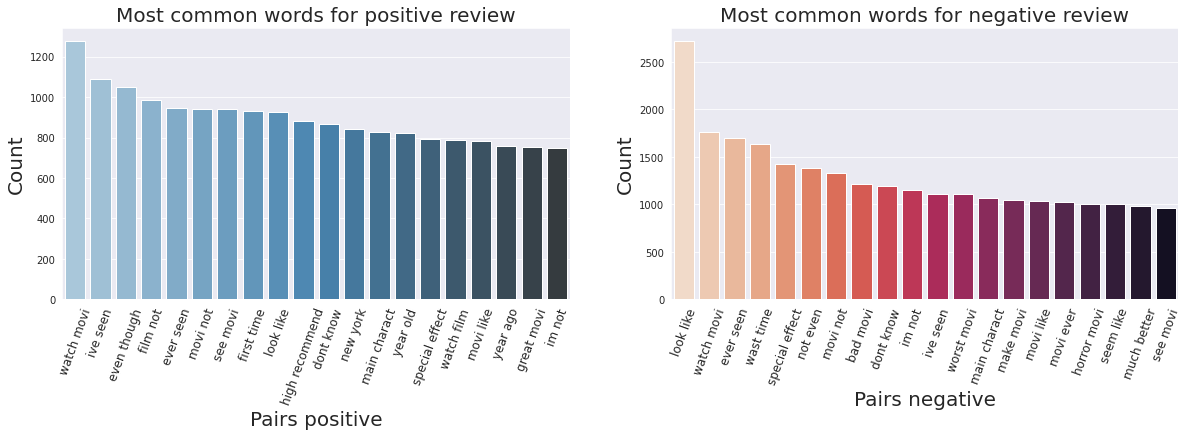

In [ ]:
# Visualization for most common bigrams for positive and negative review
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
    
sns.barplot(x = 'Review positive', y = 'count_p', data = pos_cw_df, ax = ax1, palette="Blues_d")
ax1.set_xlabel('Pairs positive', fontsize = 20)
ax1.set_ylabel('Count', fontsize = 20)
ax1.set_title('Most common words for positive review', fontsize = 20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 70, fontsize = 12);
    
sns.barplot(x = 'Review negative', y = 'count_n', data = neg_cw_df, ax = ax2, palette="rocket_r")
ax2.set_xlabel('Pairs negative', fontsize = 20)
ax2.set_ylabel('Count', fontsize = 20)
ax2.set_title('Most common words for negative review', fontsize = 20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 70, fontsize = 12);

* For positive the most common words pairs are watch movi and ive seen, for negative look like and watch movi, but they can be just some often words used
* As we can see from barplots there are some pairs which are really very important for analysis like **ever seen, high recommend, great movi** for positive and **wast time, bad movi, bad movi** for negative sentiment
* For now we will add to stopwords 'watch' and 'ive seen' as they are present in both categories of target


In [ ]:
# adding some words to stopwords after word analysis
stop_words.append('watch')
stop_words.append('ive')
stop_words.append('seen')

# Models

For modelling will be used next models:
* GaussianNB, MultinomialNB -> just to compare 2 models from Naive Bayes group
* SGDClassifier
* SVM

For estimating AUC-ROC will be used and also classification report will be added for comparing
* visualization for AUC-ROC will be done after

In [ ]:
# Function for estimating model
def est_model(X_tr, y_tr, X_ts, y_ts, model, title):
  model.fit(X_tr, y_tr)
  y_pred = model.predict(X_ts)
  y_pred_prob = model.predict_proba(X_ts)[:,1]
  print(red(title, ['bold']))
  print('AUC_ROC:', blue(roc_auc_score(y_ts, y_pred_prob), ['bold']))
  print('\nREPORT:\n', classification_report(y_pred, y_ts))
  return y_pred_prob

In [ ]:
# Separating X feature
X = messages.review_cleaned

* For vectorization TfidfVectorizer will be used as it uses TF-IDF algorythm and balances out the term frequency with its inverse document frequency
* ngram was set to 1,2 to check also pairs and three words

In [ ]:
# Vectorization with TF-IDF
vectorizer=TfidfVectorizer(min_df=0.05, max_df = 0.9, ngram_range=(1, 2), stop_words = stop_words)
cv = vectorizer.fit_transform(X).toarray()

In [ ]:
# Splitting into test and train sets
train_x, test_x, train_y, test_y = train_test_split(cv, y, test_size = 0.20, shuffle=True, stratify=y)

## Naive Bayes and Stochastic Gradient Descendent 

* SVC model will be estimated separately as this model takes a lot of time for performance

In [ ]:
# Creating instances for all mentioned models
gnb = GaussianNB()
mnb = MultinomialNB()
sgd = SGDClassifier(loss = 'modified_huber')

In [ ]:
# Estimating every model and assigning y predicted probability to use in AUC_ROC plotting
%%time
y_pred_prob_mnb = est_model(train_x, train_y, test_x, test_y, mnb, 'MultinomialNB')
y_pred_prob_gnb = est_model(train_x, train_y, test_x, test_y, gnb, 'GaussianNB')
y_pred_prob_sgd = est_model(train_x, train_y, test_x, test_y, sgd, 'SGDClassifier')

MultinomialNB
AUC_ROC: 0.9018368706576569

REPORT:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      4718
           1       0.85      0.81      0.83      5199

    accuracy                           0.82      9917
   macro avg       0.82      0.82      0.82      9917
weighted avg       0.82      0.82      0.82      9917

GaussianNB
AUC_ROC: 0.8766956949335363

REPORT:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      4776
           1       0.82      0.79      0.81      5141

    accuracy                           0.80      9917
   macro avg       0.80      0.80      0.80      9917
weighted avg       0.80      0.80      0.80      9917

SGDClassifier
AUC_ROC: 0.915281489182222

REPORT:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      4415
           1       0.88      0.80      0.84      5502

    accuracy                  

* We can see from the tables that SGDClassifier gives the best results, and from time performance point of view all models are fast, more detailed conclusions will be done after AUC-ROC visualization 

## Support Vector Machine
This model requires more time for performing that's why it is done separately

In [ ]:
# Creating instance and fitting the model
%%time
svm = SVC(kernel='linear')
svm.fit(train_x, train_y)
svm_cal = CalibratedClassifierCV(svm, cv='prefit') # To get predict_proba method Callibrated Classifier was used

# Estimating SVM model and assigning y predicted probability to use in AUC_ROC plotting
y_pred_prob_svm = est_model(train_x, train_y, test_x, test_y, svm_cal, 'SVM')

SVM
AUC_ROC: 0.9158373457174257

REPORT:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      4771
           1       0.85      0.82      0.84      5146

    accuracy                           0.83      9917
   macro avg       0.83      0.84      0.83      9917
weighted avg       0.84      0.83      0.83      9917

CPU times: user 18min 59s, sys: 1.2 s, total: 19min
Wall time: 18min 59s


* We can see that SVM model showed slightly better score but it's time performance was just big pain, so focus will be done on SGD model, will try to improve it's score to SVM level with hyperparameters tuning

## AUC-ROC visualization

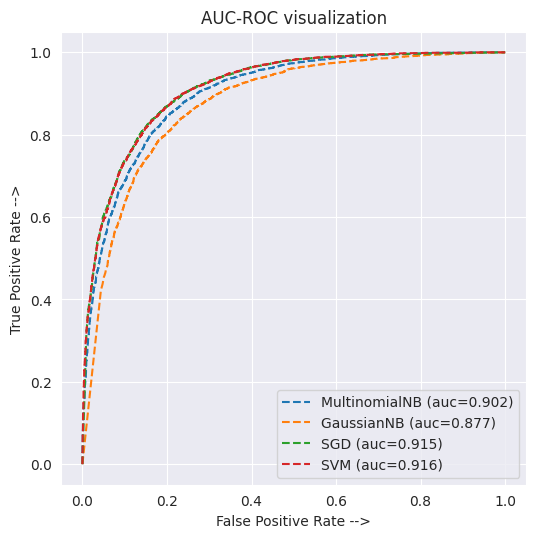

In [ ]:
# Visualization for AUC_ROC for mentioned models
mnb_fpr, mnb_tpr, threshold = roc_curve(test_y, y_pred_prob_mnb )
auc_mnb = auc(mnb_fpr, mnb_tpr)

gnb_fpr, gnb_tpr, threshold = roc_curve(test_y, y_pred_prob_gnb )
auc_gnb = auc(gnb_fpr, gnb_tpr)

sgd_fpr, sgd_tpr, threshold = roc_curve(test_y, y_pred_prob_sgd )
auc_sgd = auc(sgd_fpr, sgd_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(test_y, y_pred_prob_svm )
auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(6,6), dpi=100)
plt.plot(mnb_fpr, mnb_tpr, linestyle='--', label="MultinomialNB (auc=%0.3f)" % auc_mnb)
plt.plot(gnb_fpr, gnb_tpr, linestyle='--', label="GaussianNB (auc=%0.3f)" % auc_gnb)
plt.plot(sgd_fpr, sgd_tpr, linestyle='--', label="SGD (auc=%0.3f)" % auc_sgd)
plt.plot(svm_fpr, svm_tpr, linestyle='--', label="SVM (auc=%0.3f)" % auc_svm)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('AUC-ROC visualization')
plt.legend()
plt.show()

**Conclusions from tables and AUC-ROC plotting:**
1. As we can see from metrics the best model is SGDClassifier and SVM, MultinomialNB also behaves good
2. GaussianNB shows the worst AUC-ROC
3. From time performance point of view:
   * first NB and SGD models are very fast, of course NB are simplier, but totally 3 models performed in less then 5s so it's good result for all of them
   * SVM performed very bad despite good score
4. AUC-ROC plot also shows us the best models are SGDClassifier and SVM as they have the biggest area covered, which means they are the best at distinguishing the sentiment classes. But SVM has very bad performance and difference with SGD in scoring is very small.
5. SGD AUC-ROC is 0.91 which is very close to 1 and can be assumed as very good result
6. Some improvements can be done with hyperparameters tuning

# Hyperparameters tuning
It will be done for 2 models SGDClassifier and MultinomialNB as they showed good results and good time performance. 

SVM is bad idea in this case as grid search can take too long time for this model.

## NB

In [ ]:
tuned_parameters_mnb = {
    'alpha': [0, 0.5, 1.0, 5, 10],
    'fit_prior': [True, False]
    }
grid_search_mnb = GridSearchCV(mnb, param_grid=tuned_parameters_mnb, cv=StratifiedKFold(3), scoring='roc_auc')

In [ ]:
grid_search_mnb.fit(train_x, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 0.5, 1.0, 5, 10],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [ ]:
grid_search_mnb.best_params_

{'alpha': 0, 'fit_prior': True}

In [ ]:
# Checking auc-roc score with new hyperparameters
est_model(train_x, train_y, test_x, test_y, grid_search_mnb, 'MultinomialNB')

MultinomialNB
AUC_ROC: 0.9018523670422403

REPORT:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      4720
           1       0.84      0.81      0.83      5197

    accuracy                           0.82      9917
   macro avg       0.82      0.82      0.82      9917
weighted avg       0.82      0.82      0.82      9917



array([0.63374757, 0.77687195, 0.14488147, ..., 0.28551917, 0.66918693,
       0.43120613])

* After hyperparameters tuning score for MultinomialNB changed very little and SGD is still better model

## SGD

In [ ]:
tuned_parameters_sgd = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], # learning rate
    'loss': ['hinge', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'fit_intercept': [True, False],
    'n_jobs': [-1]
}
grid_search_sgd = GridSearchCV(sgd, param_grid=tuned_parameters_sgd,
                           cv=StratifiedKFold(3), scoring='roc_auc')

In [ ]:
grid_search_sgd.fit(train_x, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='modified_huber', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0....
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0, 10000.0],
                         'fit_intercept': [True, False],
                  

In [ ]:
grid_search_sgd.best_params_

{'alpha': 0.0001,
 'fit_intercept': True,
 'loss': 'modified_huber',
 'n_jobs': -1,
 'penalty': 'elasticnet'}

* As with parameter loss='hinge' predict_proba method is not available Callibrated Classifier was used to solve this issue.

In [ ]:
# Checking auc-roc score with new hyperparameters
sgd_cal = CalibratedClassifierCV(grid_search_sgd, cv='prefit') # To get predict_proba method Callibrated Classifier was used
est_model(train_x, train_y, test_x, test_y, sgd_cal, 'SGDClassifier')

SGDClassifier
AUC_ROC: 0.916286862889128

REPORT:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      4781
           1       0.85      0.83      0.84      5136

    accuracy                           0.83      9917
   macro avg       0.83      0.84      0.83      9917
weighted avg       0.84      0.83      0.83      9917



array([9.50600797e-01, 9.81103781e-01, 5.37630182e-04, ...,
       5.92174760e-02, 9.00886830e-01, 2.78647515e-01])

* After hyperparameters tuning AUC-ROC score become better for SGD, but change is not very significant

## Changing TfidfVectorizer parameters
We can also check if we can improve our SGD model results by doing smaller min_df and bigger max_df, which results into taking wider range of words into model

In [ ]:
# Vectorization with increased min-max_df range
vectorizer=TfidfVectorizer(min_df=0.01, max_df = 0.95, ngram_range=(1, 2), stop_words = stop_words)
cv = vectorizer.fit_transform(X).toarray()
train_x, test_x, train_y, test_y = train_test_split(cv, y, test_size = 0.20, shuffle=True, stratify=y)

In [ ]:
# Checking the best model after new vectorization
sgd = SGDClassifier(alpha=0.0001, fit_intercept=True, loss='hinge', n_jobs=-1, penalty='elasticnet')
sgd.fit(train_x, train_y)
sgd_cal = CalibratedClassifierCV(sgd, cv='prefit')
est_model(train_x, train_y, test_x, test_y, sgd_cal, 'SGDClassifier')

SGDClassifier
AUC_ROC: 0.9485649778454575

REPORT:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      4827
           1       0.89      0.87      0.88      5090

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



array([4.23518998e-03, 1.29092827e-03, 2.46515329e-02, ...,
       6.50725007e-05, 9.87552786e-01, 7.86842193e-01])

* Now we can see that AUC-ROC score is really improved to > 0.94 and report parameters are also high

# Conclusions:
* The best model for our dataset was SGDClassifier, it performed pretty fast and with very good score AUC-ROC, also model was improved by hyperparameters tuning
* MultinomialNB was the fastest model and also good, but metrics were a little bit worse then for SGD
* SVM had good metrics but just awful time performance